## Introduction

## Jupyter Notebook Setup

In [1]:
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS as stop
import string
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings

In [2]:
tf.random.set_seed(9)
# tf.random.set_random_seed(9)
warnings.filterwarnings('ignore')

stemmer = SnowballStemmer("english")
nlp = en_core_web_sm.load()
punc = set(string.punctuation)

In [3]:
# Setup before git push.
'''
Change the default plotly renderer to colab 
because plotly's plot doesn't render on the 
internet outside of certain Python environments.
Use iframe if rendering in localhost.
'''
import plotly.io as pio
pio.renderers.default = 'iframe' # for localhost
# pio.renderers.default = 'colab' # before git commit
# Rerun all cells with plotly plots after running this cell (before git commit).

## Reading The Data

In [4]:
df = pd.read_parquet('../scraped_data/reviews.parquet.gzip')
df.head()

,title,date,location,rating,text
0,"Which iPhone you should Purchase ? iPhone 8, X...",2018-12-12,India,3.0,NOTE:@ This is detailed comparison between iPh...
1,Don't buy iPhone xr from Amazon.,2018-11-17,India,1.0,Very bad experience with this iPhone xr phone....
2,Happy with the purchase,2019-01-27,India,5.0,Amazing phone with amazing camera coming from ...
3,Amazon is not an apple authorised reseller. Pl...,2019-05-02,India,1.0,So I got the iPhone XR just today. The product...
4,Excellent Battery life and buttery smooth UI,2019-05-24,India,5.0,I've been an android user all my life until I ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     3870 non-null   object        
 1   date      3870 non-null   datetime64[ns]
 2   location  3870 non-null   object        
 3   rating    3870 non-null   float32       
 4   text      3870 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 136.2+ KB


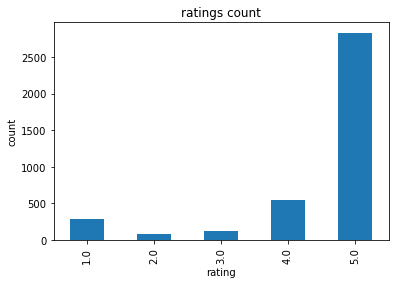

In [6]:
df['rating'].value_counts().sort_index().plot.bar(xlabel='rating', ylabel='count', title='ratings count')
plt.show()

In [7]:
def to_clean_list(doc):
    # lower text and remove punctuations
    s = ""
    for char in doc.lower():
        s += char if char not in punc else ""
    words = []
    for token in s.lower().split():
        words.append(token.strip())
    return words

## Feature Engineering & Quick EDA

In [8]:
word_counter = Counter()
positive_counter = Counter()
negative_counter = Counter()

for idx in df.index:
    doc = df.loc[idx, 'text']
    rating = df.loc[idx, 'rating']
    for i in to_clean_list(doc):
        word_counter[i] += 1
        if rating > 3:
            positive_counter[i] += 1
        else:
            negative_counter[i] += 1
        
word_counter.most_common()[:20]

[('is', 2554),
 ('the', 2483),
 ('and', 1786),
 ('i', 1532),
 ('phone', 1503),
 ('to', 1407),
 ('it', 1328),
 ('good', 1242),
 ('a', 1176),
 ('for', 1112),
 ('iphone', 1017),
 ('in', 939),
 ('this', 889),
 ('of', 832),
 ('with', 781),
 ('battery', 766),
 ('not', 729),
 ('product', 681),
 ('camera', 637),
 ('but', 635)]

In [9]:
weight_neg, weight_pos = compute_class_weight('balanced', [0,1], df['rating']>3)

In [10]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(word_counter.most_common()):
    if(cnt > 10):
        pos_neg_ratio = (positive_counter[term] * weight_pos) / float((negative_counter[term] * weight_neg)+1)
        pos_neg_ratios[term] = pos_neg_ratio
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

pos_neg_ratios.most_common()[:10]

[('perfect', 3.9846392189531774),
 ('deal', 3.8233710713570552),
 ('loved', 3.501787447229593),
 ('amazing', 3.3303210789932742),
 ('fantastic', 3.0522623493273984),
 ('lag', 2.8086402666696477),
 ('wonderful', 2.7371813026875027),
 ('love', 2.704794086108308),
 ('loving', 2.6994409747046557),
 ('beast', 2.6994409747046557)]

In [11]:
x = [i[1] for i in pos_neg_ratios.most_common()]

fig = go.Figure([go.Histogram(x=x, nbinsx=len(x)//3)])

fig.show()

In [12]:
corpus = set()

for k, v in word_counter.items():
    if v > 10:
        corpus.add(k)
        
corpus = sorted(corpus)
idx2word = dict(enumerate(corpus))
word2idx = {v:k for k, v in idx2word.items()}

len(corpus)

735

In [13]:
arr_bow = np.zeros((df.shape[0], len(corpus)), dtype=np.uint32)

arr_bow.shape

(3870, 735)

In [51]:
for row_idx, doc in enumerate(df['text']):
    for i in to_clean_list(doc):
        if i in corpus:
            col_idx = word2idx[i]
            ## One hot encoding
            arr_bow[row_idx, col_idx] = 1
            ## Bag of Words
            # arr_bow[row_idx, col_idx] += 1
        
arr_bow[:5, :30]

array([[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1]], dtype=uint32)

In [15]:
arr_bow.shape

(3870, 735)

## Removing Noise

In [52]:
(arr_bow.sum(axis=1)==0).sum()

56

In [53]:
df[arr_bow.sum(axis=1)==0]

,title,date,location,rating,text
1115,Nice !!!!,2020-02-12,India,5.0,NYC
1165,Value for money,2020-03-07,India,2.0,Awesom
1244,Superb,2019-10-16,India,5.0,Amazing.excellent.
1382,Super,2019-11-05,India,5.0,God
1560,Babboy,2019-11-12,India,5.0,Ammo
1610,Awesome,2019-11-04,India,5.0,Woooooow
1613,👌🏻,2019-09-10,India,5.0,👌🏻
1859,Best iPhone,2019-12-24,India,5.0,😜😜😜❤️❤️
1938,EXCEPT DELHIVERY SERVICES All things are good .,2019-10-07,India,5.0,Superb👌👌👌
1966,Great,2019-09-11,India,5.0,Hreat


In [54]:
X = arr_bow[arr_bow.sum(axis=1)!=0]
y = keras.utils.to_categorical(df[arr_bow.sum(axis=1)!=0]['rating'])[:, 1:]
X.shape, y.shape

((3814, 735), (3814, 5))

In [55]:
np.unique(np.argmax(y, axis=1) + 1, return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 280,   79,  126,  543, 2786]))

## Train Test Split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=9, stratify=y_train)

## Training The Model

In [57]:
model = keras.Sequential([
    keras.Input(shape=(X.shape[1],)),
    keras.layers.Dense(8, activation= 'linear'),
    keras.layers.Dense(5, activation= 'softmax')
])

optimizer = keras.optimizers.SGD(0.1)
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'AUC'])

In [58]:
callbacks = [
    # Early Stopping
    keras.callbacks.EarlyStopping(patience=12),
    # Model Checkpoint
    keras.callbacks.ModelCheckpoint(filepath= 'tf_models/bow_model.ckpt', verbose= 0, 
                                    save_best_only= True, save_weights_only= True),
    # Learning Rate Scheduler
    keras.callbacks.ReduceLROnPlateau(patience=4)
]

history = model.fit(
    X_train, y_train, batch_size=32, epochs=100, 
    validation_data=(X_val, y_val), callbacks=callbacks
)

Epoch 1/100
77/77 [==============================] - 1s 10ms/step - loss: 0.9527 - accuracy: 0.7176 - auc: 0.8789 - val_loss: 0.8270 - val_accuracy: 0.7332 - val_auc: 0.9138 - lr: 0.1000
Epoch 2/100
77/77 [==============================] - 1s 8ms/step - loss: 0.7619 - accuracy: 0.7422 - auc: 0.9281 - val_loss: 0.7837 - val_accuracy: 0.7365 - val_auc: 0.9223 - lr: 0.1000
Epoch 3/100
77/77 [==============================] - 0s 5ms/step - loss: 0.7077 - accuracy: 0.7570 - auc: 0.9372 - val_loss: 0.7522 - val_accuracy: 0.7463 - val_auc: 0.9279 - lr: 0.1000
Epoch 4/100
77/77 [==============================] - 0s 5ms/step - loss: 0.6710 - accuracy: 0.7668 - auc: 0.9432 - val_loss: 0.7371 - val_accuracy: 0.7496 - val_auc: 0.9303 - lr: 0.1000
Epoch 5/100
77/77 [==============================] - 0s 5ms/step - loss: 0.6442 - accuracy: 0.7762 - auc: 0.9476 - val_loss: 0.7405 - val_accuracy: 0.7561 - val_auc: 0.9306 - lr: 0.1000
Epoch 6/100
77/77 [==============================] - 0s 5ms/step - lo

## Load The Neural Network's Best Weight

In [59]:
model.load_weights('tf_models/bow_model.ckpt')

## Evaluating the neural network

In [60]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])

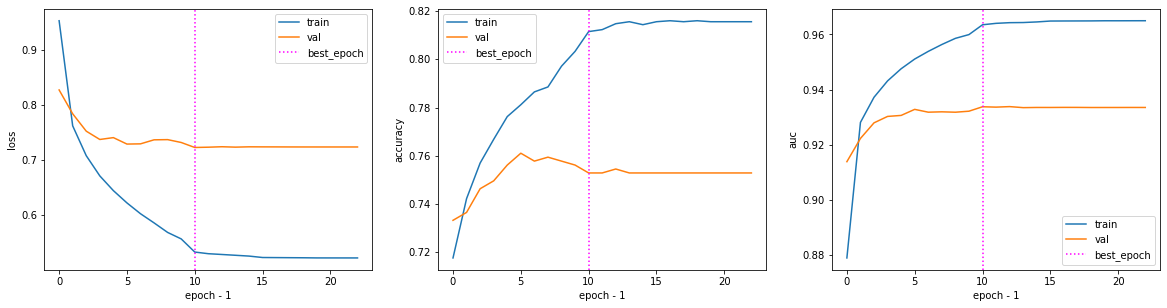

In [61]:
fig, axes = plt.subplots(1,3, figsize=(20, 4.8))

n_epoch = len(history.history['loss'])
xticks, xticksloc = range(1, n_epoch+1), range(n_epoch)
best_epoch = n_epoch - 12 - 1

for ax, to_plot in zip(axes, ['loss', 'accuracy', 'auc']):
    ax.plot(history.history[to_plot], label='train')
    ax.plot(history.history[f'val_{to_plot}'], label='val')
    ax.axvline(best_epoch, ls=':', c='magenta', label='best_epoch')
    ax.set_xlabel('epoch - 1')
    ax.set_ylabel(to_plot)
    ax.legend()

plt.show()

In [62]:
print(classification_report([np.argmax(i) + 1 for i in y_train], np.argmax(model.predict(X_train), axis=1) + 1))

              precision    recall  f1-score   support

           1       0.70      0.72      0.71       179
           2       1.00      0.06      0.11        50
           3       0.72      0.16      0.26        81
           4       0.68      0.24      0.35       347
           5       0.83      0.99      0.90      1783

    accuracy                           0.81      2440
   macro avg       0.79      0.43      0.47      2440
weighted avg       0.80      0.81      0.77      2440



In [63]:
print(classification_report([np.argmax(i) + 1 for i in y_test], np.argmax(model.predict(X_test), axis=1) + 1))

              precision    recall  f1-score   support

           1       0.61      0.59      0.60        56
           2       1.00      0.06      0.12        16
           3       0.00      0.00      0.00        25
           4       0.38      0.13      0.19       109
           5       0.81      0.97      0.88       557

    accuracy                           0.77       763
   macro avg       0.56      0.35      0.36       763
weighted avg       0.71      0.77      0.72       763



## Word2Vec Visualization

In [64]:
def sentiment(pos_neg_val):
    if pos_neg_val >= 0:
        z = 'Positive'
    else:
        z = 'Negative'
    return z

df_corpus = pd.DataFrame({
    'word':list(corpus),
    'sentiment':[sentiment(pos_neg_ratios[w]) for w in corpus],
    'pos_':[nlp(i)[0].pos_ for i in corpus]
})

df_corpus.head()

,word,sentiment,pos_
0,1,Negative,X
1,10,Negative,NUM
2,100,Positive,NUM
3,1080p,Negative,NUM
4,11,Positive,NUM


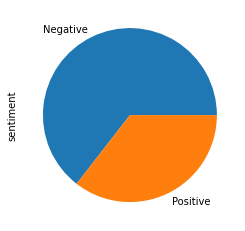

In [65]:
df_corpus['sentiment'].value_counts().plot.pie()
plt.show()

In [66]:
model.weights[0].numpy().shape

(735, 8)

In [67]:
pos_colors = np.random.choice(list(mcolors.CSS4_COLORS.values()), df_corpus['pos_'].nunique(), False)
pos_colors

array(['#FFF8DC', '#00BFFF', '#708090', '#8B008B', '#FFC0CB', '#FF00FF',
       '#6A5ACD', '#663399', '#FDF5E6', '#808080', '#2E8B57', '#4B0082',
       '#BC8F8F', '#A0522D', '#FF4500'], dtype='<U7')

In [68]:
def plot_word_scatter(points, col_mask='sentiment', colors=['red', 'green'], title=''):
    fig = go.Figure()
    for mask, c in zip(np.unique(df_corpus[col_mask]), colors):
        p = points[df_corpus[col_mask] == mask]
        n = mask
        t = df_corpus.loc[df_corpus[col_mask] == mask, 'word']
        fig.add_trace(
            go.Scatter(
                x=p[:, 0],
                y=p[:, 1],
                marker_color=c,
                mode='markers',
                name=n,
                text=t
            )
        )
    fig.update_layout(showlegend=False, title_text=title, title_x=0.5)
    fig.show()

In [69]:
tsne_scatter = TSNE(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [70]:
plot_word_scatter(tsne_scatter)

In [71]:
plot_word_scatter(tsne_scatter, 'pos_', pos_colors)

In [72]:
pca_scatter = PCA(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [73]:
plot_word_scatter(pca_scatter)

In [74]:
plot_word_scatter(pca_scatter, 'pos_', pos_colors)

In [75]:
umap_scatter = UMAP(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [76]:
plot_word_scatter(umap_scatter)

In [77]:
plot_word_scatter(umap_scatter, 'pos_', pos_colors)

In [78]:
def get_closest_words(focus):
    closest = Counter()
    weights = model.weights[0].numpy()
    x = weights[word2idx[focus]]
    for word in corpus:
        y = weights[word2idx[word]]
        ## euclidian distance
        closest[word] = np.sqrt(np.sum((x - y) ** 2))
    return closest.most_common()[::-1]

In [79]:
get_closest_words('awesome')

[('awesome', 0.0),
 ('great', 0.17740242),
 ('nice', 0.23437373),
 ('best', 0.27170125),
 ('life', 0.29817024),
 ('excellent', 0.30177605),
 ('amazing', 0.3056051),
 ('super', 0.3079195),
 ('superb', 0.31027174),
 ('love', 0.31479624),
 ('loved', 0.3185118),
 ('say', 0.32346725),
 ('delivery', 0.32461688),
 ('anything', 0.3570916),
 ('fast', 0.3604955),
 ('happy', 0.3615448),
 ('perfect', 0.36266348),
 ('for', 0.36800593),
 ('performance', 0.3680107),
 ('u', 0.37660295),
 ('thanks', 0.37765974),
 ('wonderful', 0.37997264),
 ('ios', 0.383247),
 ('everything', 0.38372222),
 ('deal', 0.38646498),
 ('still', 0.38833228),
 ('just', 0.38866127),
 ('os', 0.39994505),
 ('satisfied', 0.40380475),
 ('beast', 0.404391),
 ('simple', 0.40592942),
 ('android', 0.40993044),
 ('however', 0.4108358),
 ('enjoying', 0.4137438),
 ('provide', 0.41440237),
 ('really', 0.4146392),
 ('packaging', 0.41833135),
 ('thank', 0.41840097),
 ('won’t', 0.41960537),
 ('always', 0.4197475),
 ('others', 0.4223444),
 ('no

In [80]:
get_closest_words('disappointed')

[('disappointed', 0.0),
 ('poor', 0.13189021),
 ('bad', 0.13688365),
 ('front', 0.15091532),
 ('gets', 0.16573022),
 ('see', 0.17452645),
 ('disappointing', 0.18266064),
 ('got', 0.18268605),
 ('sold', 0.18531317),
 ('facing', 0.19328812),
 ('me', 0.19480708),
 ('should', 0.20074295),
 ('item', 0.20087995),
 ('to', 0.21062005),
 ('return', 0.2135364),
 ('old', 0.21619587),
 ('hang', 0.2197087),
 ('charging', 0.22227232),
 ('were', 0.22308925),
 ('sometimes', 0.22485171),
 ('problems', 0.22667222),
 ('has', 0.2275915),
 ('such', 0.22823082),
 ('doesnt', 0.22994445),
 ('hanging', 0.23106308),
 ('month', 0.23159318),
 ('rs', 0.23383906),
 ('take', 0.23503293),
 ('next', 0.23601271),
 ('be', 0.23678109),
 ('india', 0.24120864),
 ('slow', 0.24264017),
 ('when', 0.24355265),
 ('what', 0.24359404),
 ('bulky', 0.2438995),
 ('touch', 0.24956335),
 ('store', 0.24962081),
 ('change', 0.25072816),
 ('market', 0.2507766),
 ('buy', 0.250967),
 ('speaker', 0.25234708),
 ('privacy', 0.25359586),
 ('ne

In [81]:
get_closest_words('camera')

[('camera', 0.0),
 ('in', 0.2050895),
 ('except', 0.21893187),
 ('ever', 0.23355262),
 ('value', 0.23484154),
 ('premium', 0.24046664),
 ('till', 0.24061923),
 ('go', 0.2437477),
 ('accessories', 0.24722144),
 ('money', 0.24778073),
 ('face', 0.24857865),
 ('little', 0.25015008),
 ('smooth', 0.25101766),
 ('can', 0.2540605),
 ('affordable', 0.254712),
 ('64gb', 0.25635242),
 ('short', 0.26079416),
 ('extremely', 0.26220104),
 ('recording', 0.2640619),
 ('don’t', 0.26527348),
 ('told', 0.2653411),
 ('future', 0.26634267),
 ('scanner', 0.2667219),
 ('fine', 0.26724815),
 ('those', 0.26762158),
 ('pro', 0.2680076),
 ('button', 0.26815763),
 ('features', 0.26986855),
 ('know', 0.27072868),
 ('checked', 0.27116105),
 ('being', 0.27170688),
 ('classy', 0.27238867),
 ('app', 0.27275065),
 ('use', 0.27534813),
 ('unlock', 0.27647954),
 ('heavy', 0.27796796),
 ('display', 0.2782367),
 ('keep', 0.27954018),
 ('earphone', 0.27963),
 ('usual', 0.28120002),
 ('though', 0.28138256),
 ('would', 0.281

In [82]:
def get_cosine_similarity(focus):
    closest = Counter()
    weights = model.weights[0].numpy()
    x = weights[word2idx[focus]]
    for word in corpus:
        y = weights[word2idx[word]]
        ## cosine similarity
        closest[word] = np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
    return closest.most_common()

In [83]:
get_cosine_similarity('awesome')

[('awesome', 1.0),
 ('great', 0.97416186),
 ('best', 0.92173177),
 ('life', 0.9109144),
 ('superb', 0.9035076),
 ('nice', 0.9018816),
 ('delivery', 0.8986435),
 ('loved', 0.8973939),
 ('os', 0.8917461),
 ('others', 0.87809306),
 ('amazing', 0.8774265),
 ('love', 0.8640345),
 ('excellent', 0.861098),
 ('fast', 0.8606884),
 ('say', 0.8594219),
 ('for', 0.85802513),
 ('thanks', 0.8467724),
 ('perfect', 0.8377836),
 ('beast', 0.8285289),
 ('super', 0.82639813),
 ('still', 0.82458454),
 ('u', 0.82145375),
 ('happy', 0.81856716),
 ('performance', 0.81644464),
 ('wireless', 0.8125418),
 ('deal', 0.8090978),
 ('wonderful', 0.8020968),
 ('anything', 0.80032194),
 ('provide', 0.79529744),
 ('packaging', 0.79298156),
 ('satisfied', 0.7811628),
 ('thank', 0.7742928),
 ('update', 0.77110094),
 ('go', 0.77061075),
 ('condition', 0.7637563),
 ('ios', 0.75921243),
 ('everything', 0.7587291),
 ('makes', 0.75724626),
 ('won’t', 0.7452563),
 ('simple', 0.743493),
 ('noticed', 0.7427817),
 ('always', 0.74

In [84]:
get_cosine_similarity('disappointed')

[('disappointed', 1.0),
 ('bad', 0.95648694),
 ('poor', 0.9355687),
 ('front', 0.91807437),
 ('see', 0.915593),
 ('gets', 0.9065403),
 ('problem', 0.8910764),
 ('worst', 0.8767174),
 ('disappointing', 0.8692549),
 ('sold', 0.864085),
 ('defective', 0.8634138),
 ('facing', 0.85964125),
 ('got', 0.8569391),
 ('be', 0.8492595),
 ('item', 0.84165335),
 ('not', 0.8415962),
 ('should', 0.8360761),
 ('me', 0.83605814),
 ('privacy', 0.8143021),
 ('to', 0.8138557),
 ('return', 0.8055422),
 ('problems', 0.7947873),
 ('hang', 0.793143),
 ('such', 0.79285145),
 ('old', 0.7918788),
 ('charging', 0.7865519),
 ('india', 0.7861808),
 ('sometimes', 0.7811538),
 ('piece', 0.7771525),
 ('has', 0.7769324),
 ('take', 0.77685684),
 ('were', 0.77681285),
 ('hanging', 0.7764589),
 ('rs', 0.77453315),
 ('doesnt', 0.7744589),
 ('again', 0.7724453),
 ('next', 0.76890993),
 ('network', 0.76332927),
 ('started', 0.75906307),
 ('month', 0.7563622),
 ('market', 0.754786),
 ('service', 0.75217336),
 ('change', 0.7472

In [85]:
get_cosine_similarity('camera')

[('camera', 1.0),
 ('except', 0.8883962),
 ('good', 0.8397754),
 ('in', 0.8106781),
 ('premium', 0.8003331),
 ('money', 0.7855544),
 ('short', 0.7771679),
 ('affordable', 0.7697387),
 ('unlock', 0.7677085),
 ('extremely', 0.76474166),
 ('till', 0.74670446),
 ('go', 0.7425754),
 ('ever', 0.7346108),
 ('value', 0.7332979),
 ('accessories', 0.69188887),
 ('face', 0.6916618),
 ('little', 0.690866),
 ('pro', 0.68828607),
 ('can', 0.68425),
 ('smooth', 0.68258),
 ('know', 0.677994),
 ('don’t', 0.67557764),
 ('fine', 0.66723996),
 ('64gb', 0.6619423),
 ('scanner', 0.6582763),
 ('told', 0.6408828),
 ('recording', 0.63878),
 ('display', 0.6386686),
 ('up', 0.63274455),
 ('use', 0.6299565),
 ('future', 0.6259228),
 ('classy', 0.6245038),
 ('those', 0.6234455),
 ('button', 0.6216055),
 ('checked', 0.62127274),
 ('features', 0.61768156),
 ('earphone', 0.6082808),
 ('being', 0.6061257),
 ('would', 0.60549265),
 ('app', 0.60404104),
 ('pubg', 0.59091777),
 ('fully', 0.5877435),
 ('find', 0.58764154)